In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler # Menambahkan StandardScaler untuk Scaling
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [5]:
df = pd.read_csv('test.csv')
display(df.head(10))

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
5,5,2015-05-10 23:40:00,Sunday,TARAVAL,BROAD ST / CAPITOL AV,-122.459024,37.713172
6,6,2015-05-10 23:30:00,Sunday,INGLESIDE,100 Block of CHENERY ST,-122.425616,37.739351
7,7,2015-05-10 23:30:00,Sunday,INGLESIDE,200 Block of BANKS ST,-122.412652,37.739750
8,8,2015-05-10 23:10:00,Sunday,MISSION,2900 Block of 16TH ST,-122.418700,37.765165
9,9,2015-05-10 23:10:00,Sunday,CENTRAL,TAYLOR ST / GREEN ST,-122.413935,37.798886


In [6]:
# Salin DataFrame untuk bekerja, menjaga originalitas
df_wrangled = df.copy()

In [7]:
# --- 1. Discovery (Penemuan & Pemahaman Data) ---
print("\n--- Tahap 1: Discovery (Eksplorasi Data Awal) ---")
print("\nBentuk dataset (baris, kolom):", df_wrangled.shape)
print("\nStatistik deskriptif (numerik):")
print(df_wrangled.describe())
print("\nStatistik deskriptif (kategorikal/objek):")
print(df_wrangled.describe(include='object'))


--- Tahap 1: Discovery (Eksplorasi Data Awal) ---

Bentuk dataset (baris, kolom): (306430, 7)

Statistik deskriptif (numerik):
                  Id              X              Y
count  306430.000000  306429.000000  306429.000000
mean   153214.500000    -122.422894      37.767547
std     88458.865831       0.025538       0.023962
min         0.000000    -122.513642      37.707879
25%     76607.250000    -122.433649      37.753565
50%    153214.500000    -122.416517      37.775421
75%    229821.750000    -122.406605      37.784479
max    306429.000000    -122.364751      37.820621

Statistik deskriptif (kategorikal/objek):
                      Dates DayOfWeek PdDistrict                 Address
count                306430    306430     306430                  306430
unique               133489         7         10                   18842
top     2013-01-01 00:01:00    Friday   SOUTHERN  800 Block of BRYANT ST
freq                    103     47193      57726                    9137


In [8]:
# Cek nilai hilang
print("\nJumlah nilai hilang per kolom:")
print(df_wrangled.isnull().sum())


Jumlah nilai hilang per kolom:
Id            0
Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             1
Y             1
dtype: int64


In [9]:
# Cek duplikasi baris
print("\nJumlah baris duplikat:", df_wrangled.duplicated().sum())


Jumlah baris duplikat: 0


In [12]:
# Distribusi 'DayOfWeek' dan 'PdDistrict'
print("\nDistribusi 'DayOfWeek':")
print(df_wrangled['DayOfWeek'].value_counts(normalize=True))
print("\nDistribusi 'PdDistrict':")
print(df_wrangled['PdDistrict'].value_counts(normalize=True))


Distribusi 'DayOfWeek':
DayOfWeek
Friday       0.154009
Saturday     0.146676
Wednesday    0.144911
Thursday     0.142019
Tuesday      0.140424
Monday       0.137542
Sunday       0.134419
Name: proportion, dtype: float64

Distribusi 'PdDistrict':
PdDistrict
SOUTHERN      0.188382
MISSION       0.132653
NORTHERN      0.119195
CENTRAL       0.103668
BAYVIEW       0.098394
INGLESIDE     0.088138
TENDERLOIN    0.082949
TARAVAL       0.072653
PARK          0.060696
RICHMOND      0.053272
Name: proportion, dtype: float64


# **2. Tahapan Pembersihan Data**

In [13]:
# a. Menangani Data Duplikat (jika ada)
if df_wrangled.duplicated().sum() > 0:
    print(f"Menghapus {df_wrangled.duplicated().sum()} baris duplikat.")
    df_wrangled.drop_duplicates(inplace=True)
    print("Jumlah baris setelah menghapus duplikat:", df_wrangled.shape[0])
else:
    print("Tidak ada baris duplikat ditemukan.")

Tidak ada baris duplikat ditemukan.


In [14]:
# b. Menangani Nilai Hilang (Missing Values)
# Pada dataset ini, missing values jarang terjadi kecuali pada X, Y yang bisa berupa outlier yang salah.
# Jika ada missing values pada 'Category', 'DayOfWeek', 'PdDistrict', dll., ini harus ditangani.
# Untuk X dan Y, seringkali ada nilai -120.5 atau nilai yang tidak masuk akal.
# Mengganti nilai koordinat yang sangat tidak masuk akal dengan NaN agar bisa diimputasi
df_wrangled['X'] = df_wrangled['X'].replace(-120.5, np.nan) # Ini nilai umum yang salah untuk San Francisco
# Periksa apakah ada nilai Y yang tidak masuk akal (misal Y=90.0)
df_wrangled['Y'] = df_wrangled['Y'].replace(90.0, np.nan)

In [17]:
# Imputasi nilai hilang pada X dan Y dengan median (lebih robust terhadap outlier)
if df_wrangled['X'].isnull().any() or df_wrangled['Y'].isnull().any():
    print("Imputasi nilai hilang pada 'X' dan 'Y' dengan median.")
    imputer_coords = SimpleImputer(strategy='median')
    df_wrangled[['X', 'Y']] = imputer_coords.fit_transform(df_wrangled[['X', 'Y']])
else:
    print("Tidak ada nilai hilang yang perlu diimputasi pada 'X' dan 'Y'.")

print("\nJumlah nilai hilang setelah pembersihan (X, Y):")
print(df_wrangled.isnull().sum())

Tidak ada nilai hilang yang perlu diimputasi pada 'X' dan 'Y'.

Jumlah nilai hilang setelah pembersihan (X, Y):
Id            0
Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64


In [18]:
# c. Penanganan Outlier pada Koordinat X dan Y (Winsorization/Capping)
# Meskipun sudah diimputasi, ada baiknya melakukan capping untuk menjaga X dan Y dalam rentang realistis San Francisco.
# Rentang koordinat yang wajar untuk San Francisco:
# X (Longitude): sekitar -122.51 hingga -122.35
# Y (Latitude): sekitar 37.70 hingga 37.82
# Kita akan menggunakan persentil sebagai batas.
for col in ['X', 'Y']:
    lower_bound = df_wrangled[col].quantile(0.005) # Persentil 0.5%
    upper_bound = df_wrangled[col].quantile(0.995) # Persentil 99.5%
    df_wrangled[col] = np.clip(df_wrangled[col], lower_bound, upper_bound)
    print(f"Kolom '{col}' di-capping antara {lower_bound:.4f} dan {upper_bound:.4f}.")

Kolom 'X' di-capping antara -122.5078 dan -122.3784.
Kolom 'Y' di-capping antara 37.7099 dan 37.8081.


# **3. Structuring & Enriching (Feature Engineering)**

In [20]:
# Convert 'Dates' to datetime objects
df_wrangled['Dates'] = pd.to_datetime(df_wrangled['Dates'])

# a. Ekstraksi Fitur Waktu dari 'Dates'
df_wrangled['Year'] = df_wrangled['Dates'].dt.year
df_wrangled['Month'] = df_wrangled['Dates'].dt.month
df_wrangled['Day'] = df_wrangled['Dates'].dt.day
df_wrangled['Hour'] = df_wrangled['Dates'].dt.hour
df_wrangled['Minute'] = df_wrangled['Dates'].dt.minute
df_wrangled['DayOfWeek_Num'] = df_wrangled['Dates'].dt.dayofweek # Monday=0, Sunday=6
df_wrangled['WeekOfYear'] = df_wrangled['Dates'].dt.isocalendar().week.astype(int) # Minggu ke berapa dalam setahun
df_wrangled['TimeOfDay'] = (df_wrangled['Hour'] % 24 + 4) // 4 # Pagi, Siang, Sore, Malam (0-5: Malam, 6-11: Pagi, 12-17: Siang, 18-23: Sore)
df_wrangled['TimeOfDay'] = df_wrangled['TimeOfDay'].map({
    1: 'Dawn', 2: 'Morning', 3: 'Afternoon', 4: 'Evening', 5: 'Night', 0: 'Late Night'
}) # Mengubah angka ke label

print("\nFitur waktu baru ditambahkan:")
print(df_wrangled[['Dates', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'DayOfWeek_Num', 'WeekOfYear', 'TimeOfDay']].head())


Fitur waktu baru ditambahkan:
                Dates  Year  Month  Day  Hour  Minute  DayOfWeek_Num  \
0 2015-05-10 23:59:00  2015      5   10    23      59              6   
1 2015-05-10 23:51:00  2015      5   10    23      51              6   
2 2015-05-10 23:50:00  2015      5   10    23      50              6   
3 2015-05-10 23:45:00  2015      5   10    23      45              6   
4 2015-05-10 23:45:00  2015      5   10    23      45              6   

   WeekOfYear TimeOfDay  
0          19       NaN  
1          19       NaN  
2          19       NaN  
3          19       NaN  
4          19       NaN  


In [22]:
def get_time_of_day(hour):
    if 0 <= hour < 4:
        return 'Late Night'
    elif 4 <= hour < 8:
        return 'Dawn'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

df_wrangled['TimeOfDay'] = df_wrangled['Hour'].apply(get_time_of_day)

In [23]:
# b. Rekayasa Fitur dari 'Address' (Sederhana)
# Mengidentifikasi apakah alamat mengandung 'Block' atau 'Street' atau 'Hwy' atau 'Intersection'
df_wrangled['Is_Block'] = df_wrangled['Address'].str.contains('Block', na=False, case=False).astype(int)
df_wrangled['Is_Intersection'] = df_wrangled['Address'].str.contains('/', na=False).astype(int) # '/' seringkali menunjukkan persimpangan
df_wrangled['Is_Hwy'] = df_wrangled['Address'].str.contains('Hwy', na=False, case=False).astype(int)
print("\nFitur 'Address' baru ditambahkan (Is_Block, Is_Intersection, Is_Hwy):")
print(df_wrangled[['Address', 'Is_Block', 'Is_Intersection', 'Is_Hwy']].head())



Fitur 'Address' baru ditambahkan (Is_Block, Is_Intersection, Is_Hwy):
                    Address  Is_Block  Is_Intersection  Is_Hwy
0   2000 Block of THOMAS AV         1                0       0
1        3RD ST / REVERE AV         0                1       0
2    2000 Block of GOUGH ST         1                0       0
3  4700 Block of MISSION ST         1                0       0
4  4700 Block of MISSION ST         1                0       0


In [25]:
# c. Drop kolom yang tidak relevan atau sudah diekstrak informasinya
# 'Dates': Sudah diekstrak
# 'Id': ID unik, tidak relevan untuk prediksi kategori
# 'Address': Sudah direkayasa fiturnya, string aslinya terlalu banyak unik untuk encoding.
columns_to_drop = ['Dates', 'Id', 'Address']
# Check if columns exist before dropping
existing_columns_to_drop = [col for col in columns_to_drop if col in df_wrangled.columns]
df_processed = df_wrangled.drop(columns=existing_columns_to_drop)
print(f"\nKolom {existing_columns_to_drop} telah di-drop.")


Kolom ['Dates', 'Id', 'Address'] telah di-drop.


# **4. Tahap Transforming Data**

In [28]:
# Contoh dataframe df_wrangled, pastikan kolom 'Dates' sudah ada
df_wrangled['Dates'] = pd.to_datetime(df_wrangled['Dates'])

In [29]:
# Ekstraksi fitur waktu
df_wrangled['Year'] = df_wrangled['Dates'].dt.year
df_wrangled['Month'] = df_wrangled['Dates'].dt.month
df_wrangled['Day'] = df_wrangled['Dates'].dt.day
df_wrangled['Hour'] = df_wrangled['Dates'].dt.hour
df_wrangled['Minute'] = df_wrangled['Dates'].dt.minute
df_wrangled['DayOfWeek_Num'] = df_wrangled['Dates'].dt.dayofweek
df_wrangled['WeekOfYear'] = df_wrangled['Dates'].dt.isocalendar().week.astype(int)

In [30]:
# Fungsi kategori waktu dari jam
def get_time_of_day(hour):
    if 0 <= hour < 4:
        return 'Late Night'
    elif 4 <= hour < 8:
        return 'Dawn'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

df_wrangled['TimeOfDay'] = df_wrangled['Hour'].apply(get_time_of_day)

In [31]:
# Label Encoder
label_encoder = LabelEncoder()
df_wrangled['TimeOfDay_LabelEncoded'] = label_encoder.fit_transform(df_wrangled['TimeOfDay'])

In [32]:
# One Hot Encoder
one_hot = pd.get_dummies(df_wrangled['TimeOfDay'], prefix='TimeOfDay')
df_encoded = pd.concat([df_wrangled, one_hot], axis=1)

In [33]:
print("Contoh hasil setelah encoding:")
print(df_encoded[['TimeOfDay', 'TimeOfDay_LabelEncoded'] + list(one_hot.columns)])

Contoh hasil setelah encoding:
        TimeOfDay  TimeOfDay_LabelEncoded  TimeOfDay_Afternoon  \
0           Night                       5                False   
1           Night                       5                False   
2           Night                       5                False   
3           Night                       5                False   
4           Night                       5                False   
...           ...                     ...                  ...   
306425  Afternoon                       0                 True   
306426  Afternoon                       0                 True   
306427  Afternoon                       0                 True   
306428  Afternoon                       0                 True   
306429  Afternoon                       0                 True   

        TimeOfDay_Dawn  TimeOfDay_Evening  TimeOfDay_Late Night  \
0                False              False                 False   
1                False              False 

In [34]:
# b. Encoding Fitur Kategorikal (One-Hot Encoding)
# Kolom yang akan di-One-Hot Encode: 'DayOfWeek', 'PdDistrict', 'TimeOfDay'
ohe_cols = ['DayOfWeek', 'PdDistrict', 'TimeOfDay']

In [37]:
# Menggunakan OneHotEncoder dari sklearn.preprocessing
# Ini akan membuat array, jadi kita akan menggabungkannya kembali ke DataFrame
encoder_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # handle_unknown='ignore' untuk data test
encoded_features = encoder_ohe.fit_transform(df_encoded[ohe_cols])

In [38]:
# Mendapatkan nama kolom baru setelah One-Hot Encoding
encoded_feature_names = encoder_ohe.get_feature_names_out(ohe_cols)

In [39]:
# Membuat DataFrame dari fitur yang di-encode
df_ohe_features = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df_encoded.index)

In [41]:
# Menggabungkan kembali dengan DataFrame asli dan menghapus kolom asli yang di-encode
df_final = pd.concat([df_encoded.drop(columns=ohe_cols), df_ohe_features], axis=1)
print(f"\nKolom setelah One-Hot Encoding untuk {ohe_cols}:")
print(df_final.columns)
print(f"Bentuk setelah One-Hot Encoding: {df_final.shape}")


Kolom setelah One-Hot Encoding untuk ['DayOfWeek', 'PdDistrict', 'TimeOfDay']:
Index(['Id', 'Dates', 'Address', 'X', 'Y', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'DayOfWeek_Num', 'WeekOfYear', 'Is_Block', 'Is_Intersection',
       'Is_Hwy', 'TimeOfDay_LabelEncoded', 'TimeOfDay_Afternoon',
       'TimeOfDay_Dawn', 'TimeOfDay_Evening', 'TimeOfDay_Late Night',
       'TimeOfDay_Morning', 'TimeOfDay_Night', 'DayOfWeek_Friday',
       'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday',
       'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday',
       'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE',
       'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK',
       'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL',
       'PdDistrict_TENDERLOIN', 'TimeOfDay_Afternoon', 'TimeOfDay_Dawn',
       'TimeOfDay_Evening', 'TimeOfDay_Late Night', 'TimeOfDay_Morning',
       'TimeOfDay_Night'],
      dtype='object')
Bentu

In [42]:
# c. Scaling Fitur Numerik (Untuk Persiapan Model ML)
# Fitur numerik yang perlu di-scaling: X, Y, Year, Month, Day, Hour, Minute, DayOfWeek_Num, WeekOfYear
numeric_features_to_scale = [
    'X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'DayOfWeek_Num', 'WeekOfYear',
    'Is_Block', 'Is_Intersection', 'Is_Hwy' # Ini juga numerik biner, scaling tidak akan mengubahnya banyak tapi bisa disertakan
]

In [43]:
# Ambil hanya kolom numerik yang ada di DataFrame dan yang bukan target
actual_numeric_cols_for_scaling = [col for col in numeric_features_to_scale if col in df_final.columns and col != 'Category_Encoded']

if actual_numeric_cols_for_scaling:
    print(f"\nMelakukan Scaling (StandardScaler) pada kolom: {actual_numeric_cols_for_scaling}")
    scaler = StandardScaler()
    df_final[actual_numeric_cols_for_scaling] = scaler.fit_transform(df_final[actual_numeric_cols_for_scaling])
    print("Kolom numerik telah di-scaling.")
else:
    print("\nTidak ada kolom numerik yang teridentifikasi untuk Scaling (atau sudah di-drop).")

print("\n--- Ringkasan Dataset Akhir ---")
print(df_final.head())
print("\nInformasi dataset akhir:")
df_final.info()
print("\nJumlah nilai hilang terakhir:", df_final.isnull().sum().sum())



Melakukan Scaling (StandardScaler) pada kolom: ['X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'DayOfWeek_Num', 'WeekOfYear', 'Is_Block', 'Is_Intersection', 'Is_Hwy']
Kolom numerik telah di-scaling.

--- Ringkasan Dataset Akhir ---
   Id               Dates                   Address         X         Y  \
0   0 2015-05-10 23:59:00   2000 Block of THOMAS AV  0.916863 -1.357181   
1   1 2015-05-10 23:51:00        3RD ST / REVERE AV  1.233888 -1.466548   
2   2 2015-05-10 23:50:00    2000 Block of GOUGH ST -0.121473  1.030179   
3   3 2015-05-10 23:45:00  4700 Block of MISSION ST -0.569289 -1.926815   
4   4 2015-05-10 23:45:00  4700 Block of MISSION ST -0.569289 -1.926815   

       Year     Month       Day      Hour    Minute  ...  PdDistrict_RICHMOND  \
0  1.735184 -0.373683 -0.663166  1.451703  2.084231  ...                  0.0   
1  1.735184 -0.373683 -0.663166  1.451703  1.653392  ...                  0.0   
2  1.735184 -0.373683 -0.663166  1.451703  1.599537  ...            

In [44]:
# --- 5. Validating (Validasi Data Akhir) ---
print("\n--- Tahap 5: Validasi Akhir Data ---")
# Verifikasi tidak ada nilai NaN
if df_final.isnull().sum().sum() == 0:
    print("Validasi: Tidak ada nilai hilang ditemukan di DataFrame akhir.")
else:
    print("Validasi: PERINGATAN! Masih ada nilai hilang di DataFrame akhir.")
    print(df_final.isnull().sum()[df_final.isnull().sum() > 0]) # Tampilkan kolom dengan nilai hilang

# Verifikasi tipe data
print("\nValidasi: Tipe data akhir DataFrame:")
print(df_final.dtypes.value_counts())
if len(df_final.select_dtypes(include=['object']).columns) == 0:
    print("Validasi: Semua kolom fitur numerik (atau biner dari OHE).")
else:
    print(f"Validasi: PERINGATAN! Masih ada kolom non-numerik: {df_final.select_dtypes(include=['object']).columns.tolist()}")


--- Tahap 5: Validasi Akhir Data ---
Validasi: Tidak ada nilai hilang ditemukan di DataFrame akhir.

Validasi: Tipe data akhir DataFrame:
float64           35
bool               6
int64              2
object             1
datetime64[ns]     1
Name: count, dtype: int64
Validasi: PERINGATAN! Masih ada kolom non-numerik: ['Address']


In [45]:
# Cek rentang nilai setelah scaling
print("\nValidasi: Statistik deskriptif setelah scaling (untuk beberapa kolom):")
print(df_final[['X', 'Y', 'Hour', 'Year']].describe()) # Contoh kolom yang di-scaling


Validasi: Statistik deskriptif setelah scaling (untuk beberapa kolom):
                  X             Y          Hour          Year
count  3.064300e+05  3.064300e+05  3.064300e+05  3.064300e+05
mean   6.699217e-13  5.838575e-13 -6.167946e-17 -5.375703e-14
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00
min   -3.334968e+00 -2.405565e+00 -2.037041e+00 -1.476862e+00
25%   -4.220593e-01 -5.839578e-01 -6.718798e-01 -6.738505e-01
50%    2.513609e-01  3.288683e-01  8.654279e-02  1.291611e-01
75%    6.410185e-01  7.071838e-01  8.449654e-01  9.321727e-01
max    1.750049e+00  1.691950e+00  1.451703e+00  1.735184e+00


# **6. Tahap Penyimpanan Data**

In [46]:
# Menyimpan DataFrame yang telah dibersihkan dan ditransformasi
output_filename = 'prepared_sf_crime_data.csv'
df_final.to_csv(output_filename, index=False)
print(f"\nData yang siap disajikan telah disimpan ke '{output_filename}'")
print("Anda juga bisa menyimpan ke format lain seperti Parquet untuk performa lebih baik:")
# df_final.to_parquet('prepared_sf_crime_data.parquet', index=False)


Data yang siap disajikan telah disimpan ke 'prepared_sf_crime_data.csv'
Anda juga bisa menyimpan ke format lain seperti Parquet untuk performa lebih baik:


# **Contoh Visualisasi Data**

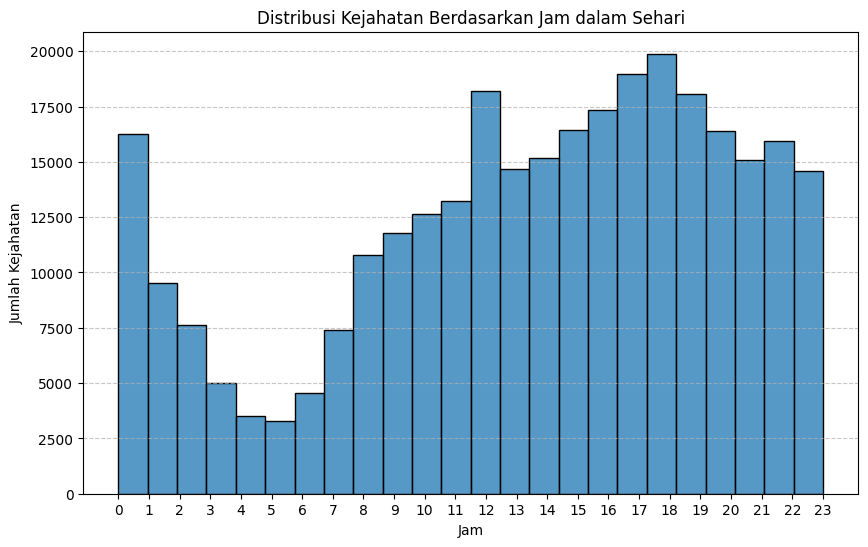

In [48]:
# Visualisasi Distribusi Kejahatan per Jam
plt.figure(figsize=(10, 6))
sns.histplot(df_wrangled['Hour'], bins=24, kde=False, stat='count') # Menggunakan df_wrangled untuk Hour asli
plt.title('Distribusi Kejahatan Berdasarkan Jam dalam Sehari')
plt.xlabel('Jam')
plt.ylabel('Jumlah Kejahatan')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<ipython-input-49-b34a833c6368>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DayOfWeek', data=df_wrangled, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='viridis')


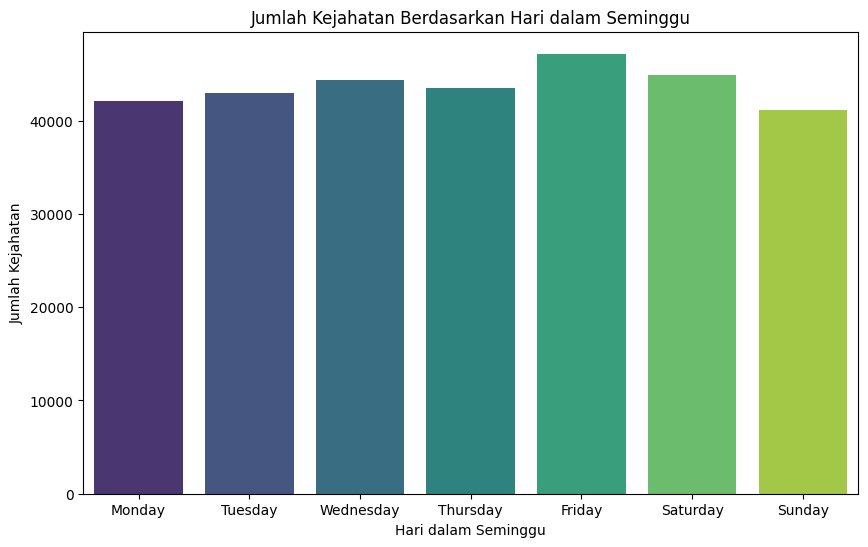

In [49]:
# Visualisasi Kejahatan per Hari dalam Seminggu
plt.figure(figsize=(10, 6))
sns.countplot(x='DayOfWeek', data=df_wrangled, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='viridis')
plt.title('Jumlah Kejahatan Berdasarkan Hari dalam Seminggu')
plt.xlabel('Hari dalam Seminggu')
plt.ylabel('Jumlah Kejahatan')
plt.show()

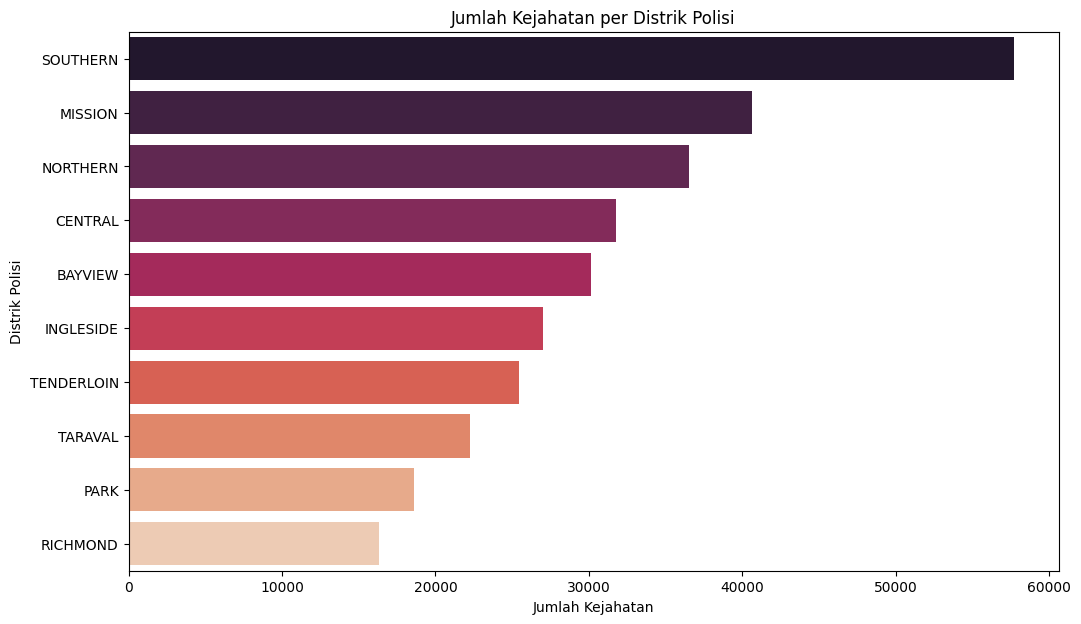

In [50]:
# Visualisasi Jumlah Kejahatan per Distrik Polisi
plt.figure(figsize=(12, 7))
sns.countplot(y='PdDistrict', data=df_wrangled, order=df_wrangled['PdDistrict'].value_counts().index, palette='rocket')
plt.title('Jumlah Kejahatan per Distrik Polisi')
plt.xlabel('Jumlah Kejahatan')
plt.ylabel('Distrik Polisi')
plt.show()

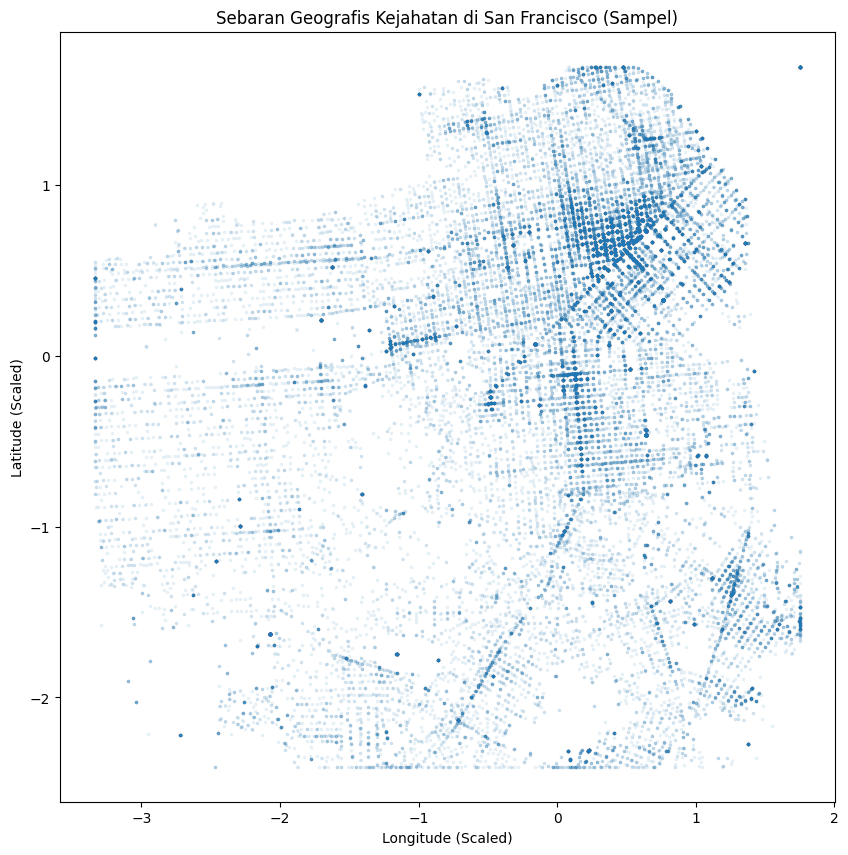


--- Data Wrangling Lengkap dan Siap Disajikan untuk Klasifikasi Kejahatan! ---


In [51]:
# Scatter plot Lokasi Kejahatan (sampel kecil untuk kinerja)
# X dan Y setelah capping, jadi outlier yang ekstrem sudah dihilangkan.
plt.figure(figsize=(10, 10))
# Ambil sampel kecil untuk visualisasi jika dataset sangat besar
sample_df = df_final.sample(n=50000, random_state=42) if len(df_final) > 100000 else df_final
sns.scatterplot(x='X', y='Y', data=sample_df, alpha=0.1, s=5, edgecolor=None)
plt.title('Sebaran Geografis Kejahatan di San Francisco (Sampel)')
plt.xlabel('Longitude (Scaled)')
plt.ylabel('Latitude (Scaled)')
plt.show()

print("\n--- Data Wrangling Lengkap dan Siap Disajikan untuk Klasifikasi Kejahatan! ---")